# Clasificación de datos – SMN

En esta sección aplicaremos **métodos de clasificación** utilizando los datos meteorológicos
procesados en la **Capa Minería de Datos**, para predecir si **llueve o no llueve** en base a variables como:

- Temperatura (`TEMP`)
- Humedad (`HUM`)
- Presión (`PNM`)
- Dirección del viento (`DD`)
- Velocidad del viento (`FF`)

Se utilizarán tres algoritmos de clasificación:

1. Árbol de Decisión
2. K-Nearest Neighbors (KNN)
3. Regresión Logística

Se evaluarán con métricas clásicas:

- **Accuracy**
- **Precision**
- **Recall**
- **F1-Score**

Y visualizaremos **matrices de confusión** para interpretar los resultados.


# Importar las librerías necesarias

In [39]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score

CLASIFICACION_DIR = Path('../data/clasificacion')
CLASIFICACION_DIR.mkdir(parents=True, exist_ok=True)

print("Importación de librerías completada.")

Importación de librerías completada.


# Carga de datos y selección de variables


In [7]:

# Cargar el dataset horario
df = pd.read_csv("../data/mineria/dataset_mineria_horario.csv")

# Variables predictoras y objetivo
X = df[['TEMP', 'HUM', 'PNM', 'DD', 'FF']]
y = df['LLUEVE']

df.head()


,NOMBRE,FECHA_HORA,FECHA,HORA,TEMP,HUM,PNM,DD,FF,estacion_archivo,LLUEVE
0,IGUAZU AERO,2024-06-01 00:00:00,2024-06-01,0,13.8,91.0,1019.6,90.0,7.0,20240601.0,0
1,IGUAZU AERO,2024-06-01 01:00:00,2024-06-01,1,13.4,92.0,1019.5,90.0,7.0,20240601.0,0
2,IGUAZU AERO,2024-06-01 02:00:00,2024-06-01,2,13.0,94.0,1019.0,90.0,11.0,20240601.0,0
3,IGUAZU AERO,2024-06-01 03:00:00,2024-06-01,3,12.8,94.0,1018.3,90.0,9.0,20240601.0,0
4,IGUAZU AERO,2024-06-01 04:00:00,2024-06-01,4,12.4,94.0,1018.3,90.0,7.0,20240601.0,0


# División en conjuntos de entrenamiento y prueba


In [8]:


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Dimensiones de los conjuntos de datos:")
print(f"  X_train: {X_train.shape} -> {X_train.shape[0]} filas, {X_train.shape[1]} variables predictoras")
print(f"  X_test : {X_test.shape} -> {X_test.shape[0]} filas, {X_test.shape[1]} variables predictoras")
print(f"  y_train: {y_train.shape[0]} filas")
print(f"  y_test : {y_test.shape[0]} filas")

print("\nDistribución de clases en entrenamiento:")
print(y_train.value_counts(normalize=True))

print("\nDistribución de clases en prueba:")
print(y_test.value_counts(normalize=True))


Dimensiones de los conjuntos de datos:
  X_train: (14101, 5) -> 14101 filas, 5 variables predictoras
  X_test : (6044, 5) -> 6044 filas, 5 variables predictoras
  y_train: 14101 filas
  y_test : 6044 filas

Distribución de clases en entrenamiento:
LLUEVE
0    0.879583
1    0.120417
Name: proportion, dtype: float64

Distribución de clases en prueba:
LLUEVE
0    0.87955
1    0.12045
Name: proportion, dtype: float64


# Estandarización de variables
Para KNN y regresión logística es importante escalar las variables numéricas.

In [14]:
# Crear y ajustar el escalador
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Mostrar información interpretativa
print("=== Estandarización de variables ===")
print("Antes de escalar (primeras 5 filas):")
print(X_train.head())

print("\nDespués de escalar (primeras 5 filas):")
print(pd.DataFrame(X_train_scaled, columns=X_train.columns).head())

=== Estandarización de variables ===
Antes de escalar (primeras 5 filas):
       TEMP   HUM     PNM     DD    FF
16821  35.2  42.0  1009.0  290.0  22.0
11239  14.0  71.0  1019.6  140.0  13.0
15018  25.2  79.0  1009.9   50.0   6.0
923    10.2  90.0  1020.8  270.0   9.0
19227  19.9  85.0  1016.8   90.0  11.0

Después de escalar (primeras 5 filas):
       TEMP       HUM       PNM        DD        FF
0  2.030664 -1.953787 -0.835534  0.856043  2.543028
1 -1.271255 -0.260781  1.204696 -0.113604  0.799963
2  0.473155  0.206255 -0.662307 -0.695392 -0.555754
3 -1.863108  0.848430  1.435665  0.726756  0.025268
4 -0.352324  0.556532  0.665767 -0.436820  0.412616


# Entrenamiento de modelos de clasificación

In [19]:
print("=== Entrenamiento de Modelos de Clasificación ===\n")

# Árbol de Decisión - No necesita estandarización porque no depende de la magnitud de las variables.
model_tree = DecisionTreeClassifier(random_state=42)
model_tree.fit(X_train, y_train)
print("Modelo Árbol de Decisión entrenado.")
print(f"Profundidad del árbol: {model_tree.get_depth()}")
print(f"Número de hojas: {model_tree.get_n_leaves()}\n")

# K-Nearest Neighbors (KNN) - Necesita variables escaladas para que la distancia euclidiana sea representativa.
neighbors = 5
model_knn = KNeighborsClassifier(n_neighbors= neighbors)
model_knn.fit(X_train_scaled, y_train)
print("Modelo KNN entrenado (con datos estandarizados).")
print(f"Número de vecinos usados: {model_knn.n_neighbors}")
print(f"Forma de los datos entrenados: {model_knn._fit_X.shape}\n")

# Regresión Logística - También requiere estandarización para mejorar la convergencia del algoritmo.
model_log = LogisticRegression(max_iter=1000, random_state=42)
model_log.fit(X_train_scaled, y_train)
print("Modelo de Regresión Logística entrenado (con datos estandarizados).")
print("Coeficientes por variable (impacto en la probabilidad de lluvia):")
for var, coef in zip(X_train.columns, model_log.coef_[0]):
    print(f"  {var}: {coef:.4f}")
print(f"Intersección (bias): {model_log.intercept_[0]:.4f}")

=== Entrenamiento de Modelos de Clasificación ===

Modelo Árbol de Decisión entrenado.
Profundidad del árbol: 2
Número de hojas: 3

Modelo KNN entrenado (con datos estandarizados).
Número de vecinos usados: 5
Forma de los datos entrenados: (14101, 5)

Modelo de Regresión Logística entrenado (con datos estandarizados).
Coeficientes por variable (impacto en la probabilidad de lluvia):
  TEMP: -0.1712
  HUM: 3.4919
  PNM: -5.5691
  DD: -0.0903
  FF: -0.1263
Intersección (bias): -7.0516


## Interpretación del Entrenamiento de Modelos

Luego de entrenar los tres modelos de clasificación, obtenemos información sobre su estructura y parámetros:

### Árbol de Decisión
- **Profundidad**: Indica cuántas divisiones jerárquicas se realizaron.
- **Número de hojas**: Cada hoja representa una **clase final** (llueve / no llueve).

En el ejemplo:
- Profundidad: `2` → Árbol muy simple, fácil de interpretar.
- Hojas: `3` → Tres rutas posibles de decisión.

> **Interpretación:**  
Un árbol con baja profundidad es más interpretable, pero puede perder precisión si el fenómeno es complejo.  
Se busca un equilibrio entre simplicidad y desempeño.

---

### K-Nearest Neighbors (KNN)
- **Número de vecinos usados**: `5`  
- **Forma de los datos entrenados**: `(14101, 5)`  

Esto significa:
- El modelo **almacena todo el conjunto de entrenamiento** para calcular distancias.  
- Usa **5 vecinos más cercanos** para decidir si llueve o no.  
- Cada fila tiene **5 variables predictoras**: `TEMP`, `HUM`, `PNM`, `DD`, `FF`.

> **Interpretación:**  
KNN es un modelo **basado en similitud**.  
No aprende reglas explícitas, sino que **compara nuevas observaciones** con las ya conocidas.

---

### Regresión Logística
Imprime los **coeficientes de cada variable** y el **intercepto (bias)**.

- **Coeficientes**: Indican cómo cambia la **probabilidad de lluvia** según cada variable:  
  - Positivo → aumenta la probabilidad de lluvia  
  - Negativo → disminuye la probabilidad de lluvia  

Ejemplo interpretativo:
- `HUM` positivo → mayor humedad favorece la lluvia.
- `PNM` negativo → baja presión favorece la lluvia.
- `TEMP` negativo → temperaturas altas reducen la probabilidad de lluvia.

- **Intercepto (bias)**: `-7.0516`  
  - Representa la **tendencia base** del modelo cuando todas las variables están en sus valores promedio (tras la estandarización).  
  - Es un **log-odds**, que se puede convertir en probabilidad:  

\[
p = \frac{1}{1 + e^{-(-7.0516)}} \approx 0.00086
\]

Esto significa que **la probabilidad de lluvia base es muy baja**, y solo aumentará si las variables lo justifican (humedad alta y presión baja).

---

### Resumen
- **Árbol de Decisión**: genera reglas explícitas y es interpretable.  
- **KNN**: no genera reglas, clasifica por similitud con vecinos cercanos.  
- **Regresión Logística**: asigna un **peso** a cada variable y una probabilidad de lluvia.  
- El **bias negativo** indica que el modelo, sin señales claras, tiende a predecir **“no llueve”**.


# Evaluación de modelos
Se usarán **accuracy, precision, recall y F1-score**, junto con la **matriz de confusión** para visualizar los aciertos y errores.


=== Árbol de Decisión ===
Accuracy : 1.000 -> Proporción total de aciertos
Precision: 1.000 -> De los 'llueve' predichos, cuántos fueron correctos
Recall   : 1.000 -> De las lluvias reales, cuántas detectó el modelo
F1-Score : 1.000 -> Balance entre Precision y Recall


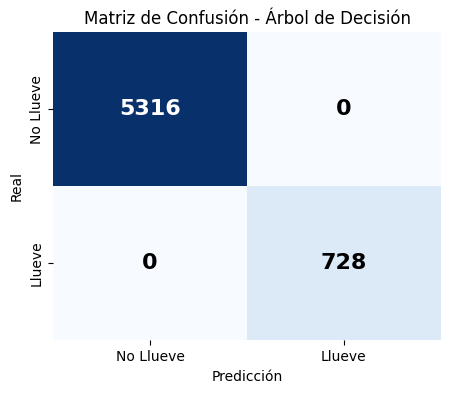


=== KNN ===
Accuracy : 0.983 -> Proporción total de aciertos
Precision: 0.955 -> De los 'llueve' predichos, cuántos fueron correctos
Recall   : 0.900 -> De las lluvias reales, cuántas detectó el modelo
F1-Score : 0.926 -> Balance entre Precision y Recall


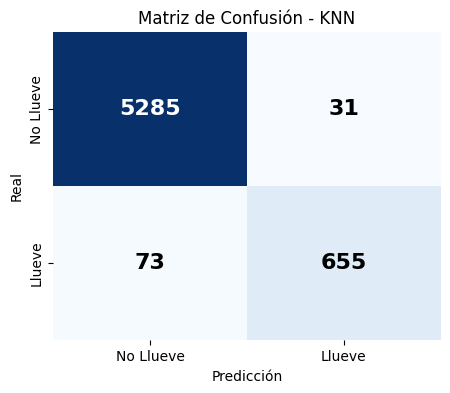


=== Regresión Logística ===
Accuracy : 0.949 -> Proporción total de aciertos
Precision: 0.822 -> De los 'llueve' predichos, cuántos fueron correctos
Recall   : 0.736 -> De las lluvias reales, cuántas detectó el modelo
F1-Score : 0.777 -> Balance entre Precision y Recall


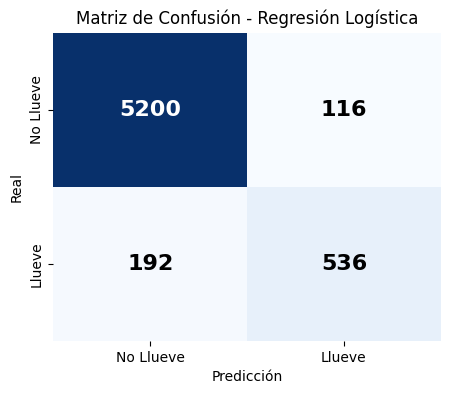

In [24]:
# Evaluar un modelo mostrando métricas y matriz de confusión.
def evaluar_modelo(nombre, modelo, X_eval, y_eval):
    
    y_pred = modelo.predict(X_eval)

    # === Métricas ===
    acc = accuracy_score(y_eval, y_pred)
    prec = precision_score(y_eval, y_pred)
    rec = recall_score(y_eval, y_pred)
    f1 = f1_score(y_eval, y_pred)

    print(f"\n=== {nombre} ===")
    print(f"Accuracy : {acc:.3f} -> Proporción total de aciertos")
    print(f"Precision: {prec:.3f} -> De los 'llueve' predichos, cuántos fueron correctos")
    print(f"Recall   : {rec:.3f} -> De las lluvias reales, cuántas detectó el modelo")
    print(f"F1-Score : {f1:.3f} -> Balance entre Precision y Recall")

    # === Matriz de Confusión ===
    cm = confusion_matrix(y_eval, y_pred)

    plt.figure(figsize=(5,4))
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                     xticklabels=["No Llueve","Llueve"], 
                     yticklabels=["No Llueve","Llueve"])

    # Cambiar color de texto según el valor
    max_val = cm.max()
    for text in ax.texts:
        val = int(text.get_text())
        # Blanco si valor alto, negro si valor bajo
        text.set_color("white" if val > max_val/2 else "black")
        text.set_size(16)
        text.set_weight('bold')

    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title(f"Matriz de Confusión - {nombre}")
    plt.show()

    return [acc, prec, rec, f1]

# Evaluación de los tres modelos
resultados = []
resultados.append(evaluar_modelo("Árbol de Decisión", model_tree, X_test, y_test))
resultados.append(evaluar_modelo("KNN", model_knn, X_test_scaled, y_test))
resultados.append(evaluar_modelo("Regresión Logística", model_log, X_test_scaled, y_test))


## Comparativa de métricas

In [25]:
df_resultados = pd.DataFrame(resultados, columns=["Accuracy","Precision","Recall","F1-Score"],
                             index=["Árbol de Decisión","KNN","Regresión Logística"])
df_resultados


,Accuracy,Precision,Recall,F1-Score
Árbol de Decisión,1.000000,1.000000,1.000000,1.000000
KNN,0.982793,0.954810,0.899725,0.926450
Regresión Logística,0.949040,0.822086,0.736264,0.776812


## Cierre de comparativa de métricas

- El modelo con mayor **accuracy** indica la mejor capacidad de predicción global.
- La **precisión** muestra cuántos de los eventos predichos como lluvia fueron correctos.
- El **recall** indica cuántas lluvias reales fueron detectadas.
- El **F1-score** balancea precisión y recall, útil si las clases están desbalanceadas.

**Interpretación típica:**
- Si KNN tiene buen F1-score pero bajo accuracy, es sensible al desbalance.
- Si Árbol de Decisión obtiene buen accuracy pero menor recall, puede estar subestimando lluvias.
- La elección final depende de priorizar **detectar lluvias** (recall) o **evitar falsas alarmas** (precision).


# Guardar el dataset con las predicciones realizadas

In [42]:
# Generar DataFrame con predicciones y probabilidades
df_predicciones = df.loc[y_test.index, ["NOMBRE","FECHA_HORA","LLUEVE"]].copy()

# Predicciones
df_predicciones["tree_pred"] = model_tree.predict(X_test)
df_predicciones["knn_pred"] = model_knn.predict(X_test_scaled)
df_predicciones["log_pred"] = model_log.predict(X_test_scaled)

# Probabilidades de lluvia
df_predicciones["knn_proba"] = model_knn.predict_proba(X_test_scaled)[:,1]
df_predicciones["log_proba"] = model_log.predict_proba(X_test_scaled)[:,1]

# Crear DataFrame de métricas comparativas
df_metricas = pd.DataFrame(resultados, 
                           columns=["Accuracy","Precision","Recall","F1-Score"],
                           index=["Árbol de Decisión","KNN","Regresión Logística"])

# Guardar como CSV

# Guardar los datasets con las predicciones realizadas. Exportación a CSV
df_predicciones.to_csv(CLASIFICACION_DIR / 'clasificacion_predicciones.csv', index=False)
print("Archivo 'clasificacion_predicciones.csv' generado correctamente.")

# Guardar como CSV
df_metricas.to_csv(CLASIFICACION_DIR / 'clasificacion_metricas.csv', index=False)
print("Archivo 'clasificacion_metricas.csv' generado correctamente.")

Archivo 'clasificacion_predicciones.csv' generado correctamente.
Archivo 'clasificacion_metricas.csv' generado correctamente.


# Visualizaciones

## Curva ROC y AUC

La **Curva ROC (Receiver Operating Characteristic)** muestra la capacidad del modelo para distinguir entre clases.
- **Eje X**: Falsos positivos (1 - Especificidad)
- **Eje Y**: Verdaderos positivos (Recall o Sensibilidad)
- **AUC**: Área bajo la curva; cuanto más cercano a 1, mejor el modelo.

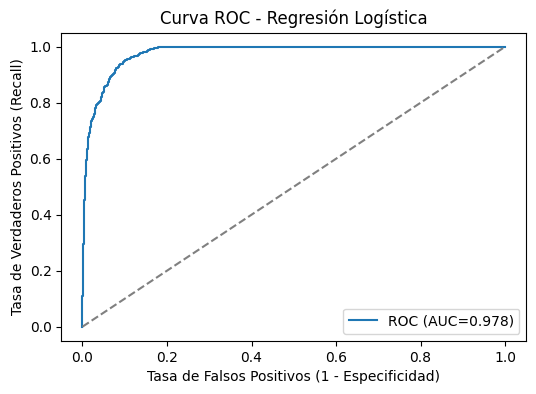

In [27]:
# Ejemplo con Regresión Logística
y_proba = model_log.predict_proba(X_test_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"ROC (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("Tasa de Falsos Positivos (1 - Especificidad)")
plt.ylabel("Tasa de Verdaderos Positivos (Recall)")
plt.title("Curva ROC - Regresión Logística")
plt.legend()
plt.show()


## Importancia de Variables (Árbol de Decisión)

El **Árbol de Decisión** permite visualizar qué variables tuvieron más influencia para predecir si llueve o no.


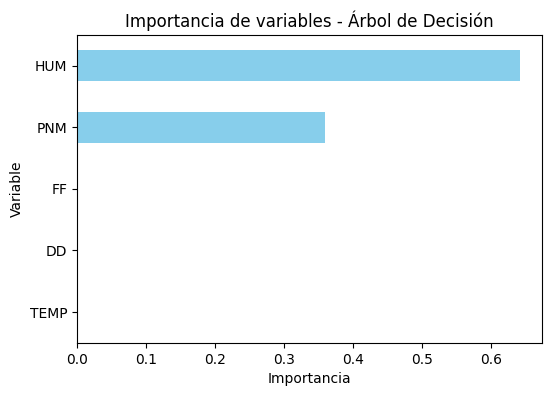

In [28]:
importancia = pd.Series(model_tree.feature_importances_, index=X_train.columns)
importancia.sort_values().plot(kind='barh', figsize=(6,4), color='skyblue')
plt.title("Importancia de variables - Árbol de Decisión")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.show()

## Matriz de Confusión Normalizada

La matriz normalizada muestra la proporción de aciertos y errores por clase, facilitando la interpretación cuando hay clases desbalanceadas.

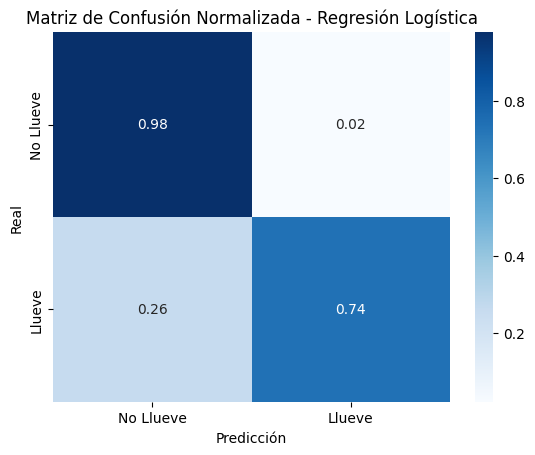

In [29]:
cm = confusion_matrix(y_test, model_log.predict(X_test_scaled), normalize='true')
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=["No Llueve","Llueve"], yticklabels=["No Llueve","Llueve"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión Normalizada - Regresión Logística")
plt.show()


## Distribución de Probabilidades Predichas

La distribución de probabilidades permite ver:
- Qué tan seguro está el modelo al predecir
- Cómo se superponen las clases
- Dónde está el umbral de decisión (por defecto 0.5)

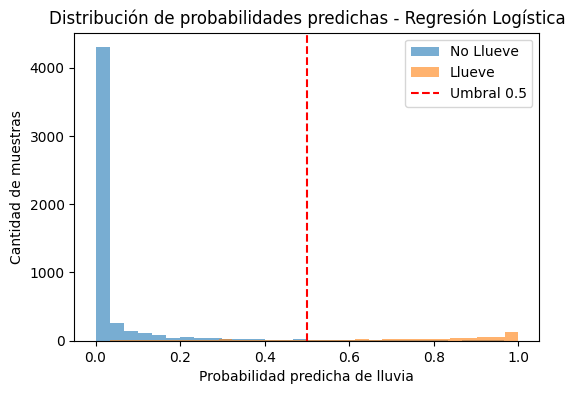

In [30]:
y_proba = model_log.predict_proba(X_test_scaled)[:,1]

plt.figure(figsize=(6,4))
plt.hist(y_proba[y_test==0], bins=30, alpha=0.6, label='No Llueve')
plt.hist(y_proba[y_test==1], bins=30, alpha=0.6, label='Llueve')
plt.axvline(0.5, color='red', linestyle='--', label='Umbral 0.5')
plt.xlabel("Probabilidad predicha de lluvia")
plt.ylabel("Cantidad de muestras")
plt.title("Distribución de probabilidades predichas - Regresión Logística")
plt.legend()
plt.show()


## Comparativa de Métricas entre Modelos

Permite ver de manera clara cuál modelo tiene mejor:
- Accuracy
- Precision
- Recall
- F1-Score


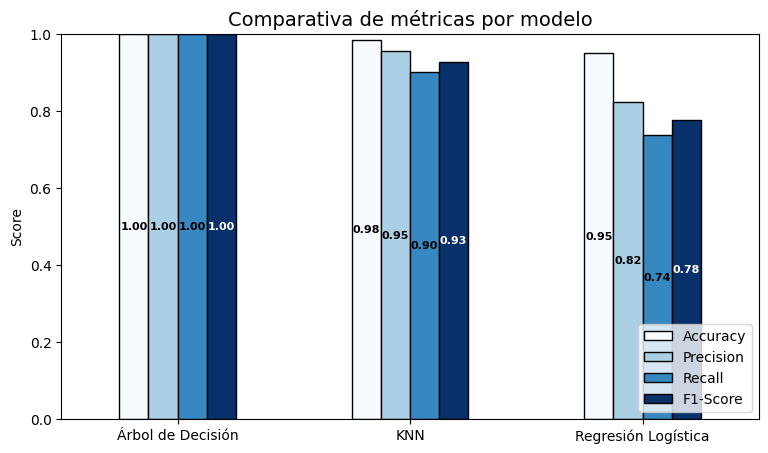

In [36]:
# DataFrame con resultados
df_resultados = pd.DataFrame(resultados, 
                             columns=["Accuracy","Precision","Recall","F1-Score"],
                             index=["Árbol de Decisión","KNN","Regresión Logística"])

# Crear gráfico de barras con Blues y bordes
ax = df_resultados.plot(
    kind='bar', figsize=(9,5), rot=0, 
    colormap='Blues', edgecolor='black'
)

plt.title("Comparativa de métricas por modelo", fontsize=14)
plt.ylabel("Score")
plt.ylim(0,1)
plt.legend(loc='lower right')

# Etiquetas dentro de las barras: blancas solo para F1-Score
for i, container in enumerate(ax.containers):
    # i=0 Accuracy, i=1 Precision, i=2 Recall, i=3 F1-Score
    color_text = 'white' if i == 3 else 'black'
    ax.bar_label(container, fmt='%.2f', label_type='center', fontsize=8, color=color_text, weight='bold')


plt.show()


# Conclusión

En esta etapa se trabajó sobre el **dataset final proveniente de la etapa de minería de datos**, donde la información ya había sido procesada y contenía la variable binaria `LLUEVE` como objetivo de clasificación.  
El objetivo principal fue **aplicar métodos de clasificación supervisada** para predecir la ocurrencia de lluvia a partir de datos meteorológicos horarios.

Se realizaron los siguientes pasos clave:

1. **Selección de variables relevantes** (`TEMP`, `HUM`, `PNM`, `DD`, `FF`) como insumos para los modelos de clasificación.  
2. **Estandarización de los datos** para algoritmos sensibles a la escala, como KNN y Regresión Logística.  
3. **División del dataset en conjuntos de entrenamiento y prueba** para evaluar objetivamente el desempeño de los modelos.  
4. **Entrenamiento y evaluación de modelos supervisados** (Árbol de Decisión, KNN y Regresión Logística) utilizando métricas como Accuracy, Precision, Recall y F1-Score.  
5. **Visualizaciones complementarias** como matrices de confusión, curvas ROC, histogramas de probabilidades y análisis de importancia de variables, que permitieron interpretar los resultados y validar el desempeño de cada modelo.

Este proceso consolida la etapa de **clasificación supervisada**, transformando los datos procesados en **conocimiento accionable**, y dejando una base sólida para **predicciones futuras, integración en pipelines analíticos y toma de decisiones basadas en datos**.

